In [263]:
import datetime
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from db_utils.db_queries import sql_all_reports_with_weather
# from db_utils.mysql_db_connection import get_mysql_connection

from webscraping.scrape_fishing_data import clean_string

## Read and format the data

In [28]:
fishing_data = pd.read_csv("./raw_fishing_data.csv")

In [70]:
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23


In [29]:
# convert the date to a date object for consistency in our analysis + make pandas happy
fishing_data.loc[:, 'date_posted'] = pd.to_datetime(fishing_data.loc[:, 'date_posted'], format="%Y-%m-%d", cache=True)

# clean punctuation from the post bodies. makes our lives harder and doesnt contribute much
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(clean_string)

## Check for duplicate rows 

In [187]:
fishing_data.loc[fishing_data.duplicated(subset=['headline', 'post_body', 'date_posted'], keep=False)].sort_values("date_posted")

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
2548,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87
2547,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87
2478,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41
2477,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41
2354,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81
2353,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81
2336,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90
2335,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90
2332,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96
2331,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96


There are 13 duplicate posts that leaked into the data. We'll get rid of these so they don't skew any of our analysis.

In [188]:
fishing_data = fishing_data.drop_duplicates().reset_index(drop=True)
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23


## Duplicate dates

In [189]:
# are there multiple posts for any days?
post_counts = fishing_data.date_posted.value_counts()
post_counts[post_counts >= 2]

2017-09-26    9
2017-04-30    9
2018-04-21    7
2017-04-28    7
2017-12-05    7
             ..
2014-07-10    2
2019-07-10    2
2014-07-13    2
2013-08-15    2
2007-07-29    2
Name: date_posted, Length: 410, dtype: int64

Is it concerning that dates are duplicated? Let's check one of the dates that has 9 posts.

In [192]:
sample_date = pd.Timestamp(datetime.date(2017, 9, 26))
duplicate_date_example = fishing_data.loc[fishing_data.date_posted == sample_date]
duplicate_date_example

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
498,2017-09-26,Excellent Start Kimura 8 Day,We departed Sunday on our annual Gary Kimura 8...,63.0,69.92,78.0,0.0,10.0,10.0,29.82
499,2017-09-26,beautiful dorados today,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
500,2017-09-26,beautiful yellowtail,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
501,2017-09-26,happy camper,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
502,2017-09-26,YELLOWTAIL BONANZA,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82
503,2017-09-26,Matt,Matt brings in a beautiful Yellowtail,63.0,69.92,78.0,0.0,10.0,10.0,29.82
504,2017-09-26,Alex,Nice yellow today,63.0,69.92,78.0,0.0,10.0,10.0,29.82
505,2017-09-26,Robert,Robert says Hello to all my friends,63.0,69.92,78.0,0.0,10.0,10.0,29.82
506,2017-09-26,trip 1722 Jackpot winners,First place Tim Brown 57 8 Second place Vince ...,63.0,69.92,78.0,0.0,10.0,10.0,29.82


There seem to be days where the crew posts many times, sometimes without a post body. It's likely that these are accompanied by pictures on the actual site since the headlines are things like, `Matt brings in a beautiful Yellowtail`, though we didn't webscrape photos. More posts in a day may be an indicator of good fishing conditions. 

## When do posts happen?

#### Let's see how posts are distributed by year

In [72]:
# What is the earliest post and the most recent post by date?
sorted_dates = fishing_data.date_posted.sort_values()
sorted_dates.iloc[0], sorted_dates.iloc[-1]

(Timestamp('2005-06-19 00:00:00'), Timestamp('2020-12-19 00:00:00'))

In [83]:
# uncomment this to see just the numbers per year (useful for spotchecking the bar plot)
# fishing_data.date_posted.dt.year.value_counts()

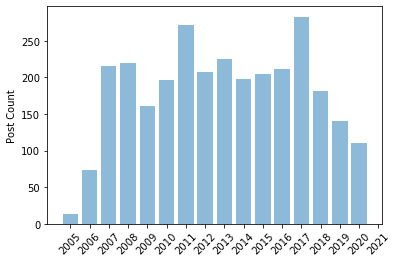

In [139]:
time_hist_options = {
    "alpha":  0.5,
    "rwidth": 0.8,
    "bins":   np.arange(2005, 2020 + 2),
    "align":  "left"
}
plt.hist(fishing_data.date_posted.dt.year, **time_hist_options)
plt.ylabel("Post Count")
plt.xticks(time_hist_options['bins'], rotation=45);

Posts were fairly consistent in the late 2000s and 2010s, though this is clear dropoff in recent years. Drops in 2020 were almost certainly correlated with covid though there was an existing downward trend.

Note: The average post per day is less than 1 for every year in the dataset. Because the crew didn't post every day, it's likely that good days are overrepresented.

#### What about the distribution by month? Is there seasonality to the posts?

In [84]:
# uncomment this to see just the numbers per month (useful for spotchecking the bar plot)
# fishing_data.date_posted.dt.month.value_counts()

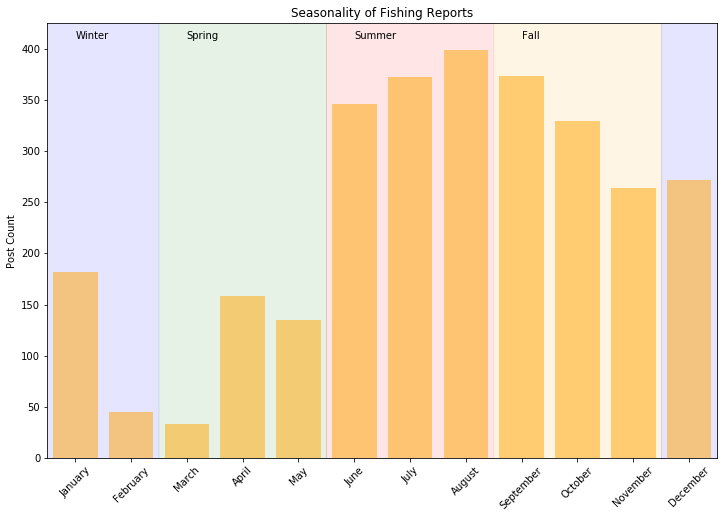

In [142]:
plt.figure(figsize=(12, 8))
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]
month_hist_options = {
    "alpha":  0.5,
    "rwidth": 0.8,
    "bins":   np.arange(1, 12 + 2),
    "align":  "left",
    "color":  "orange"
}
plt.hist(fishing_data.date_posted.dt.month, **month_hist_options)
plt.ylabel("Post Count")
plt.xticks(month_hist_options['bins'], labels=month_labels, rotation=45);


# Custom fill patterns to emphasize seasons. Not super important
plt.fill_between([2.5, 5.49], 500, alpha=0.1, color='green', label='Spring')
plt.fill_between([5.5, 8.49], 500, alpha=0.1, color='red', label='Summer')
plt.fill_between([8.5, 11.49], 500, alpha=0.1, color='orange', label='Fall')

plt.fill_between([0, 2.49], 500, alpha=0.1, color='blue', label='Winter')
plt.fill_between([11.5, 12.5], 500, alpha=0.1, color='blue')

plt.xlim([0.5, 12.5])
plt.ylim([0, 425])

plt.annotate("Winter", [1, 410])
plt.annotate("Spring", [3, 410])
plt.annotate("Summer", [6, 410])
plt.annotate("Fall", [9, 410])

plt.title("Seasonality of Fishing Reports");

plt.savefig("post_seasonality.png", dpi=500)

Though posts aren't necessarily equivalent to business activity, this plot suggests that the fishing business may be more active in hotter months. This makes intuitive sense since we wouldn't expect people to be out in the rain or cold to catch fish, especially when the waters may be choppy or otherwise le.

### Rain patterns over the years

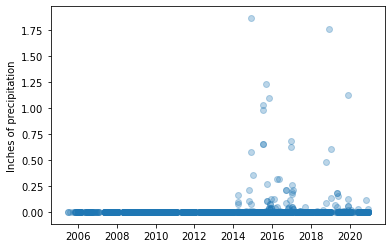

In [73]:
plt.scatter(fishing_data.date_posted.values, fishing_data.inches_precip.values, alpha=0.3)
plt.ylabel("Inches of precipitation");

Before 2014 there is no rain data. Either the site we scraped weather data from didn't have correct measurements of the rain or we got unlucky and none of the posts occurred on days where there was rain. Given that there aren't many posts during rainy months, the latter is possible. We shouldn't use rain for anything serious in our analysis.

## Daily Temperatures

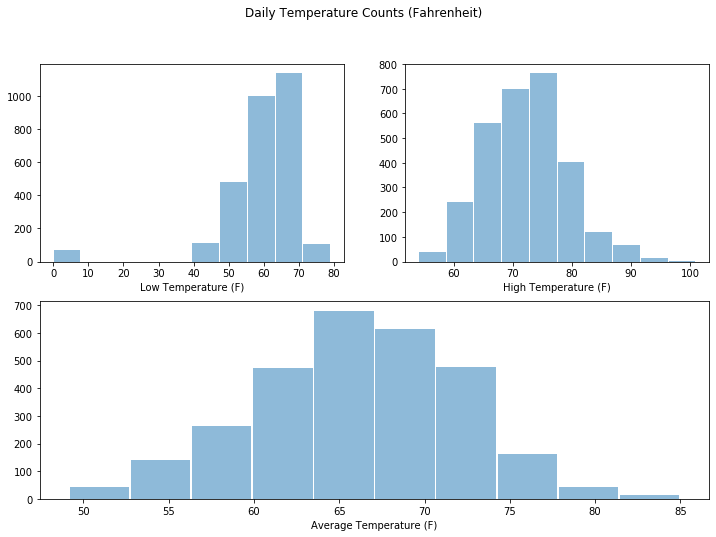

In [179]:
# thanks for the grid help: 
# https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib
import matplotlib.gridspec as gridspec

temp_plot_options = {
    "alpha":  0.5,
    "rwidth": 0.97
}

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 8))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.suptitle("Daily Temperature Counts (Fahrenheit)")

plt.hist(fishing_data.low_temp, **temp_plot_options)
plt.xlabel("Low Temperature (F)")

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.hist(fishing_data.high_temp, **temp_plot_options)
plt.xlabel("High Temperature (F)")

ax = plt.subplot(gs[1, :]) # row 1, span all columns
plt.hist(fishing_data.avg_temp, **temp_plot_options)
plt.xlabel("Average Temperature (F)");

The daily low temperatures have outlier values near 0. San Diego doesn't randomly hit sub-freezing temperatures, skipping everything from 32 down to 0, so we can be sure these are errors in the weather site's data.

As for the rest of the temperatures, the average and high look well-behaved. It may be worth looking for relationships between temperature and post content.

## What are the posts about?

For a first pass, we can simply look at the top words used (ignoring filler words)

In [193]:
# We'll ignore these words. They're too common to be useful
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
       'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
       'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
       'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
       'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
       'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
       'just', 'don', 'should', 'now']

In [194]:
stopwords = set(stopwords)

In [195]:
all_posts = " ".join(fishing_data.post_body.values)

In [200]:
tokens = all_posts.lower().split()
tokens = [t for t in tokens if t not in stopwords]

n = 20
top_n_words = pd.Series(tokens).value_counts().iloc[:n]

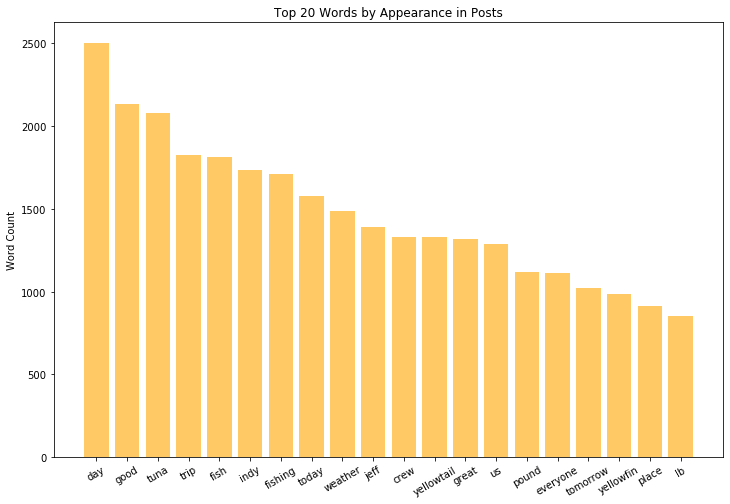

In [211]:
plt.figure(figsize=(12, 8))

plt.bar(top_n_words.index, top_n_words.values, alpha=0.6, color='orange')
plt.xticks(rotation=30)

plt.title(f"Top {n} Words by Appearance in Posts")
plt.ylabel("Word Count");

With the stopwords removed, we get mostly unique words with distinct meanings. It's a good sign that `tuna`, `yellowtail`, and `yellowfin` appear in the top words since we are more likely to be able to extract something interesting from the text. Additionally, `pound` and `lb` appearing are indicators that some posts are likely discussing the size of their catches. 

# TODO: calculate pointwise mutual information of words and find interesting phrases
# TODO: see if spacy can do better

# TODO: Topic model and visualize topics
# TODO: find a way to extract fish species and measure mentions

In [213]:
minimum_chars = 5
non_empty_posts = fishing_data.loc[fishing_data.loc[:, "post_body"].apply(lambda x: len(x.strip())) > minimum_chars]

In [216]:
non_empty_posts.shape, fishing_data.shape

((2759, 10), (2896, 10))

Pointwise mutual information is defined as,

$$PMI(i, j) = log_2\frac{p(w_i, w_j)}{p(w_i)p(w_j)}$$

To calculate this matrix, we need word counts to estimate the relevant probabilities.

In [217]:
from sklearn.feature_extraction.text import CountVectorizer

In [218]:
vectorizer = CountVectorizer()

In [219]:
vectorized_docs = vectorizer.fit_transform(non_empty_posts.post_body)

In [230]:
vocab = pd.Series(vectorizer.vocabulary_).sort_values().index.values
vocab

array(['00', '000', '00am', ..., 'zuckers', 'zuker', 'zuri'], dtype=object)

In [238]:
document_wordcounts = np.array(vectorized_docs.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [266]:
# compute cooccurrence. 
# This is extremely expensive. don't rerun if you can avoid it


# masked_doc_matrix = document_wordcounts > 0
# cooccurrence_matrix = np.zeros([len(vocab), len(vocab)])

# for i in range(len(vocab)):
#     word_i_occurrence = masked_doc_matrix[:, i]
#     for j in range(i, len(vocab)):
#         word_j_occurrence = masked_doc_matrix[:, j]
#         shared_doc_count = (word_i_occurrence & word_j_occurrence).sum()
        
#         cooccurrence_matrix[i, j] = shared_doc_count
#         cooccurrence_matrix[j, i] = shared_doc_count
#     if i % 100 == 0:
#         print(f"finishing word {i}")

# np.save("cooccurrence.npy", cooccurrence_matrix)

In [267]:
cooccurrence_matrix = np.load("cooccurrence.npy")
cooccurrence_matrix

array([[42.,  1.,  2., ...,  0.,  0.,  2.],
       [ 1., 14.,  0., ...,  0.,  0.,  2.],
       [ 2.,  0., 12., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  2.,  0.],
       [ 2.,  2.,  0., ...,  0.,  0., 16.]])

In [272]:
smoothing_factor = 1e-5
cooccurrence_matrix += smoothing_factor

In [273]:
# TODO: this can be easily done in pure numpy but I dont remember the cleanest way
joint_prob = np.array([row / row.sum() for row in cooccurrence_matrix])
joint_prob

array([[1.31452273e-02, 3.12984658e-04, 6.25966186e-04, ...,
        3.12981528e-09, 3.12981528e-09, 6.25966186e-04],
       [6.10105662e-04, 8.54139996e-03, 6.10099561e-09, ...,
        6.10099561e-09, 6.10099561e-09, 1.22020522e-03],
       [3.33848715e-03, 1.66923523e-08, 2.00308395e-02, ...,
        1.66923523e-08, 1.66923523e-08, 1.66923523e-08],
       ...,
       [2.07867044e-08, 2.07867044e-08, 2.07867044e-08, ...,
        6.23603211e-03, 2.07867044e-08, 2.07867044e-08],
       [4.06377295e-08, 4.06377295e-08, 4.06377295e-08, ...,
        4.06377295e-08, 8.12758654e-03, 4.06377295e-08],
       [7.24883788e-04, 7.24883788e-04, 3.62440082e-09, ...,
        3.62440082e-09, 3.62440082e-09, 5.79904494e-03]])

In [288]:
word_frequencies = document_wordcounts.sum(axis=0)
word_frequencies = word_frequencies / word_frequencies.sum()
word_frequencies

array([2.49652567e-04, 6.24131417e-05, 6.24131417e-05, ...,
       1.24826283e-05, 8.32175223e-06, 9.57001506e-05])

In [289]:
def pmi(i, j):
    return np.log2(joint_prob[i, j]) - np.log2(word_frequencies[i]) - np.log2(word_frequencies[j])

In [291]:
pmi(0, 0)

17.686264178076826